# Redes neurais artificiais do zero em Python

Referência: Andrej Karpathy. The spelled-out intro to neural networks and backpropagation: building micrograd (2022). https://www.youtube.com/watch?v=VMj-3S1tku0

## Construindo um grafo computacional automaticamente

In [1]:
from graphviz import Digraph


def _tracar(folha):
    """Função modificada da criada por Andrej Karpathy para construção de grafo.

    Referência: https://github.com/karpathy/micrograd

    """
    vertices = set()
    arestas = set()

    def construir(v):
        """Função recursiva para traçar o grafo."""
        if v not in vertices:
            vertices.add(v)
            for progenitor in v.progenitor:
                arestas.add((progenitor, v))
                construir(progenitor)

    construir(folha)

    return vertices, arestas


def plota_grafo(folha):
    """Função modificada da criada por Andrej Karpathy para construção de grafo.

    Referência: https://github.com/karpathy/micrograd

    """
    grafo = Digraph(format="svg", graph_attr={"rankdir": "LR"})
    vertices, arestas = _tracar(folha)

    for v in vertices:
        id_vertice = str(id(v))

        if hasattr(v, "rotulo") and (hasattr(v, "grad")):
            texto = "{ " + f"{v.rotulo} | data {v.data:.3f} | grad {v.grad:.3f}" + " }"

        elif hasattr(v, "rotulo"):
            texto = "{ " + f"{v.rotulo} | data {v.data:.3f}" + " }"

        else:
            texto = "{ " + f"data {v.data:.3f}" + " }"

        grafo.node(name=id_vertice, label=texto, shape="record")

        if v.operador_mae:
            grafo.node(name=id_vertice + v.operador_mae, label=v.operador_mae)
            grafo.edge(id_vertice + v.operador_mae, id_vertice)

    for vertice1, vertice2 in arestas:
        grafo.edge(str(id(vertice1)), str(id(vertice2)) + vertice2.operador_mae)

    return grafo

In [2]:
import math

class Valor:
    def __init__(self, data, progenitor=(), operador_mae="", rotulo=""):
        self.data = data
        self.progenitor = progenitor
        self.operador_mae = operador_mae
        self.rotulo = rotulo
        self.grad = 0

    def __repr__(self):
        return f"Valor(data={self.data})"
    
    def __add__(self, outro_valor):
        """Realiza a operação: self + outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data + outro_valor.data
        operador_mae = "+"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_adicao():
            self.grad += resultado.grad
            outro_valor.grad += resultado.grad
            
        resultado.propagar = propagar_adicao
        
        return resultado
    
    def __mul__(self, outro_valor):
        """Realiza a operação: self * outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data * outro_valor.data
        operador_mae = "*"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_multiplicacao():
            self.grad += resultado.grad * outro_valor.data # grad_filho * derivada filho em relação a mãe
            outro_valor.grad += resultado.grad * self.data
            
        resultado.propagar = propagar_multiplicacao
        
        return resultado
    
    def exp(self):
        """Realiza a operação: exp(self)"""
        progenitor = (self, )
        data = math.exp(self.data)
        operador_mae = "exp"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_exp():
            self.grad += resultado.grad * data 
        
        resultado.propagar = propagar_exp
        
        return resultado
    
    def __pow__(self, expoente):
        """Realiza a operação: self ** expoente"""
        assert isinstance(expoente, (int, float))
        progenitor = (self, )
        data = self.data ** expoente
        operador_mae = f"**{expoente}"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_pow():
            self.grad += resultado.grad * (expoente * self.data ** (expoente - 1))
        
        resultado.propagar = propagar_pow
        
        return resultado
    
    def __truediv__(self, outro_valor):
        """Realiza a operação: self / outro_valor"""
        return self * outro_valor ** (-1)
    
    def __neg__(self):
        """Realiza a operação: -self"""
        return self * -1
    
    def __sub__(self, outro_valor):
        """Realiza a operação: self - outro_valor"""
        return self + (-outro_valor)
    
    def __radd__(self, outro_valor):
        """Realiza a operação: outro_valor + self"""
        return self + outro_valor
    
    def __rmul__(self, outro_valor):
        """Realiza a operação: outro_valor * self"""
        return self * outro_valor
    
    def sig(self):
        """Realiza a operação: exp(self) / (exp(self) + 1)"""
        return self.exp() / (self.exp() + 1)
    
    def propagar(self):
        pass
    
    def propagar_tudo(self):
        
        self.grad = 1
        
        ordem_topologica = []
        
        visitados = set()

        def constroi_ordem_topologica(v):
            if v not in visitados:
                visitados.add(v)
                for progenitor in v.progenitor:
                    constroi_ordem_topologica(progenitor)
                ordem_topologica.append(v)

        constroi_ordem_topologica(self)
        
        for vertice in reversed(ordem_topologica):
            vertice.propagar()

In [23]:
a = Valor(10)
print(a)

Valor(data=10)


In [24]:
b = Valor(5)
print(b)

Valor(data=5)


In [25]:
c = a + b

In [26]:
print(c)

Valor(data=15)


In [27]:
c.progenitor

(Valor(data=10), Valor(data=5))

In [28]:
c.operador_mae

'+'

In [29]:
d = a * b

In [30]:
print(d)

Valor(data=50)


In [31]:
d.progenitor

(Valor(data=10), Valor(data=5))

In [33]:
d.operador_mae

'*'

In [32]:
b.progenitor

()

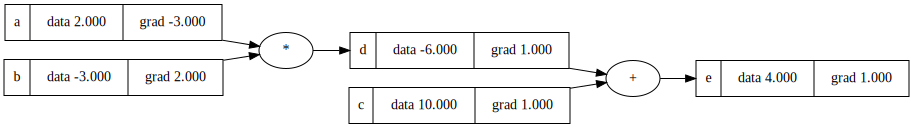

In [42]:
a = Valor(2, rotulo="a")
b = Valor(-3, rotulo="b")
c = Valor(10, rotulo="c")

d = a * b
d.rotulo = "d"
e = d + c
e.rotulo = "e"

e.grad = 1  # de/de
c.grad = 1  # de/dc   e = d + c
d.grad = 1  # de/dd

a.grad = -3  # de/da = 1 * -3   d = a * b
b.grad = 2  # de/db = 1 * 2

plota_grafo(e)

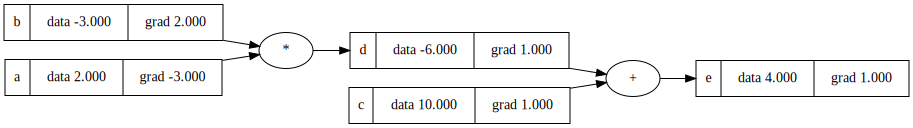

In [56]:
a = Valor(2, rotulo="a")
b = Valor(-3, rotulo="b")
c = Valor(10, rotulo="c")

d = a * b
d.rotulo = "d"
e = d + c
e.rotulo = "e"

e.propagar_tudo()

plota_grafo(e)

In [ ]:
# autograd

![img](https://i.imgur.com/Q3MA6dZ.png)

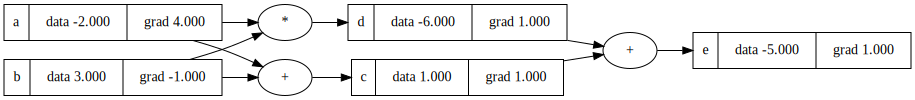

In [59]:
a = Valor(-2, rotulo="a")
b = Valor(3, rotulo="b")

c = a + b
d = a * b

e = c + d

c.rotulo = "c"
d.rotulo = "d"
e.rotulo = "e"

e.propagar_tudo()
plota_grafo(e)

In [63]:
a = Valor(10, rotulo="a")
b = a + 1
print(b)

Valor(data=11)


In [61]:
1.data

SyntaxError: invalid decimal literal (110494918.py, line 1)

In [66]:
a = Valor(10, rotulo="a")
b = a * 10
print(b)

Valor(data=100)


In [69]:
a = Valor(10, rotulo="a")
b = 1 + a
print(b)

Valor(data=11)


In [72]:
a = Valor(10, rotulo="a")
b = 10 * a
print(b)

Valor(data=100)


In [76]:
a = Valor(1, rotulo="a")
b = a.exp()  # exp(a) ~ 2.718
print(b)

Valor(data=2.718281828459045)


In [79]:
a = Valor(10, rotulo="a")
b = a**2
print(b)

Valor(data=100)


In [82]:
a = Valor(1, rotulo="a")
b = Valor(2, rotulo="b")
c = a / b
print(c)

Valor(data=0.5)


In [85]:
a = Valor(1, rotulo="a")
b = -a
print(b)

Valor(data=-1)


In [88]:
a = Valor(10, rotulo="a")
b = Valor(3, rotulo="b")
c = a - b
print(c)

Valor(data=7)


$$
S(x) = \frac{e^x}{e^x + 1}
$$

In [94]:
a = Valor(0, rotulo="a")
b = a.sig()
print(b)

Valor(data=0.5)


# Construindo e treinando uma rede neural

In [37]:
import random

class Neuronio:
    def __init__(self, num_dados_entrada):
        self.vies = Valor(random.uniform(-1, 1))
        
        self.pesos = []
        for i in range(num_dados_entrada):
            self.pesos.append(Valor(random.uniform(-1, 1)))
            
    def __call__(self, x):
        
        assert len(x) == len(self.pesos)
        
        soma = 0
        for info_entrada, peso_interno in zip(x, self.pesos):
            soma += info_entrada * peso_interno
            
        soma += self.vies  
        dado_de_saida = soma.sig()
        
        return dado_de_saida       
    
    def parametros(self):
        return self.pesos + [self.vies]

In [16]:
dados_de_entrada = [2.5, 4.25]

meu_neuronio = Neuronio(len(dados_de_entrada))

print(meu_neuronio(dados_de_entrada))

Valor(data=0.11147898580822475)


In [11]:
meu_neuronio.pesos

[Valor(data=0.41619462502215865), Valor(data=-0.9182036611106141)]

In [9]:
meu_neuronio.vies

Valor(data=0.981433016424972)

In [41]:
class Camada:
    def __init__(self, num_neuronios, num_dados_entrada):
        neuronios = []
        
        for _ in range(num_neuronios):
            neuronio = Neuronio(num_dados_entrada)
            neuronios.append(neuronio)
            
        self.neuronios = neuronios     
        
    def __call__(self, x):
        dados_de_saida = []
        
        for neuronio in self.neuronios:
            informacao = neuronio(x)
            dados_de_saida.append(informacao)
            
        if len(dados_de_saida) == 1:
            return dados_de_saida[0]
        else:        
            return dados_de_saida  
    
    def parametros(self):
        params = []
        
        for neuronio in self.neuronios:
            params_neuronio = neuronio.parametros()
            params.extend(params_neuronio)
        
        return params

In [40]:
a = [1,2,3]
b = [2,3,4]
a.extend(b)
print(a)

[1, 2, 3, 2, 3, 4]


In [18]:
dados_de_entrada = [2.5, 4.25]
num_neuronios = 3

minha_camada = Camada(num_neuronios, len(dados_de_entrada))

print(minha_camada(dados_de_entrada))

[Valor(data=0.9163211841785524), Valor(data=0.2624169160410059), Valor(data=0.9376500966220815)]


In [49]:
class MLP:
    def __init__(self, num_dados_entrada, num_neuronios_por_camada):
        
        percurso = [num_dados_entrada] + num_neuronios_por_camada
        
        camadas = []
        
        for i in range(len(num_neuronios_por_camada)):
            camada = Camada(num_neuronios_por_camada[i], percurso[i])
            camadas.append(camada)
            
        self.camadas = camadas
        
    def __call__(self, x):
        for camada in self.camadas:
            x = camada(x)
        return x
    
    def parametros(self):
        params = []
        
        for camada in self.camadas:
            parametros_camada = camada.parametros()
            params.extend(parametros_camada)
            
        return params

In [19]:
[2] + [1,2,3]

[2, 1, 2, 3]

In [22]:
dados_de_entrada = [2.5, 4.25]
num_neuronios_por_camada = [4, 3, 1]

minha_mlp = MLP(len(dados_de_entrada), num_neuronios_por_camada)

resultado = minha_mlp(dados_de_entrada)

print(resultado)

Valor(data=0.46047419418588004)


In [26]:
minha_mlp.camadas[0].neuronios[0].vies

Valor(data=-0.8150721057488066)

In [29]:
resultado.propagar_tudo()
grafo = plota_grafo(resultado)

# para salvar o grafo
grafo.render("rede_neural", format="png")

'rede_neural.png'

In [50]:
x = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

y_true = [1, 0, 0.2, 0.5]

In [51]:
NUM_DADOS_DE_ENTRADA = 3  
NUM_DADOS_DE_SAIDA = 1    
CAMADAS_OCULTAS = [3, 2]  

arquitetura_da_rede = CAMADAS_OCULTAS + [NUM_DADOS_DE_SAIDA]

minha_mlp = MLP(NUM_DADOS_DE_ENTRADA, arquitetura_da_rede)

In [52]:
y_pred = []

for exemplo in x:
    previsao = minha_mlp(exemplo)
    y_pred.append(previsao)
    
print(y_pred)

[Valor(data=0.28595954607853724), Valor(data=0.25350996462984354), Valor(data=0.2777701054518107), Valor(data=0.27729634856766483)]


In [53]:
erros = []

for yt, yp in zip(y_true, y_pred):
    residuo = yp - yt
    erro_quadratico = residuo ** 2
    erros.append(erro_quadratico)
    
loss = sum(erros)
print(loss)

Valor(data=0.6297661776662739)


In [35]:
loss.propagar_tudo()
grafo = plota_grafo(loss)

# para salvar o grafo
grafo.render("rede_neural_perda", format="png")

'rede_neural_perda.png'

In [54]:
parametros = minha_mlp.parametros()

print(len(parametros))
print()
parametros

23



[Valor(data=-0.9045042753794521),
 Valor(data=0.6812048730086333),
 Valor(data=-0.6338208767224711),
 Valor(data=-0.77605435330915),
 Valor(data=-0.6701648831100757),
 Valor(data=0.9287733553464845),
 Valor(data=0.46742154415641224),
 Valor(data=0.5718586673833599),
 Valor(data=-0.18074542821492945),
 Valor(data=-0.3236406406321515),
 Valor(data=0.19914969921662173),
 Valor(data=0.13501743419666212),
 Valor(data=0.4974473557679506),
 Valor(data=0.1399178852474352),
 Valor(data=-0.04950535651170962),
 Valor(data=-0.07686251330120797),
 Valor(data=-0.5143535268097388),
 Valor(data=-0.5979816431469607),
 Valor(data=0.05915332840469789),
 Valor(data=-0.5892376763729319),
 Valor(data=0.4132261001862667),
 Valor(data=-0.9038214886715754),
 Valor(data=-0.963775365296782)]

In [61]:
TAXA_DE_APRENDIZADO = 0.01

loss.propagar_tudo()

for p in parametros:
    #print(p.grad)
    p.data = p.data - p.grad * TAXA_DE_APRENDIZADO

In [62]:
y_pred = []

for exemplo in x:
    previsao = minha_mlp(exemplo)
    y_pred.append(previsao)
    
print(y_pred)

[Valor(data=0.29360168313981033), Valor(data=0.2599582473654984), Valor(data=0.28495094157341), Valor(data=0.28458872067450647)]


In [63]:
erros = []

for yt, yp in zip(y_true, y_pred):
    residuo = yp - yt
    erro_quadratico = residuo ** 2
    erros.append(erro_quadratico)
    
loss = sum(erros)
print(loss)

Valor(data=0.6201955541711054)


In [185]:
x = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

y_true = [1, 0, 0.2, 0.5]

NUM_DADOS_DE_ENTRADA = 3  
NUM_DADOS_DE_SAIDA = 1    
CAMADAS_OCULTAS = [3, 2]  

arquitetura_da_rede = CAMADAS_OCULTAS + [NUM_DADOS_DE_SAIDA]

minha_mlp = MLP(NUM_DADOS_DE_ENTRADA, arquitetura_da_rede)

In [186]:
NUM_EPOCAS = 200
TAXA_DE_APRENDIZADO = 0.5

for epoca in range(NUM_EPOCAS):
    # forward pass
    y_pred = []
    for exemplo in x:
        previsao = minha_mlp(exemplo)
        y_pred.append(previsao)

    # loss
    erros = []
    for yt, yp in zip(y_true, y_pred):
        residuo = yp - yt
        erro_quadratico = residuo ** 2
        erros.append(erro_quadratico)        
    loss = sum(erros)

    # zero grad
    for p in minha_mlp.parametros():
        p.grad = 0

    # backpropagation
    loss.propagar_tudo()

    # atualiza parâmetros
    for p in minha_mlp.parametros():
        p.data = p.data - p.grad * TAXA_DE_APRENDIZADO

    # mostra resultado (opcional)
    print(epoca, loss.data)

0 0.5894905352020262
1 0.5733131758655007
2 0.5646724209577468
3 0.5598439189803952
4 0.5569040392728359
5 0.5548788000777037
6 0.5532739336431711
7 0.5518352818307821
8 0.5504292538572204
9 0.5489831940075204
10 0.5474554314562603
11 0.5458201281144637
12 0.5440595806026379
13 0.5421603167276597
14 0.5401111409614442
15 0.5379021871948882
16 0.5355244926317219
17 0.5329698388387768
18 0.5302307255367579
19 0.52730040513247
20 0.5241729392552725
21 0.520843256847801
22 0.5173072038083208
23 0.5135615803219281
24 0.5096041655759195
25 0.5054337313994766
26 0.5010500470039032
27 0.49645387680208336
28 0.4916469725868052
29 0.4866320604461365
30 0.4814128219367211
31 0.47599386839764957
32 0.4703807069662898
33 0.4645796968822213
34 0.45859799501377124
35 0.4524434901579082
36 0.44612472647461937
37 0.4396508173389172
38 0.43303135184188896
39 0.42627629706133174
40 0.41939589997019244
41 0.41240059338160373
42 0.4053009105782823
43 0.3981074131926488
44 0.3908306364633504
45 0.3834810551

In [187]:
y_true

[1, 0, 0.2, 0.5]

In [188]:
y_pred

[Valor(data=0.875598372898164),
 Valor(data=0.10832881882138648),
 Valor(data=0.20307076535529534),
 Valor(data=0.5223815691594085)]